## Week5: Vision Transformer

금주 실습은 ViT를 직접 구현하고, ImageNet Classification까지 완료하는 것이 목표입니다.

### What to submit

02/20(목) 10:00까지 Ipynb파일을 https://github.com/mlvc-lab/MLVC-Tutorial.git 해당 레포에 업로드해주세요.

경로는 2025_Internship/Week5/{filename} 입니다.

파일명은 Week5_이름(한글로).ipynb로 통일해주세요. Ex: Week5_이의준.ipynb

## Part A. Data loading

이번 주 실습에 사용할 데이터셋은 MinyImageNet입니다! Imagenette는 클래스 개수가 10개로 적기 때문에, 클래스 개수가 1000개인 subset을 준비했습니다.

torchvision에서 제공하는 데이터셋이 아니기때문에, CustomDataset을 구현해야 합니다.

데이터셋은 MinyImageNet.sh 파일을 bash로 실행하면 지정된 경로에 다운로드됩니다. (경로 확인 필수)

In [94]:
import os
import cv2
import json
import torch
import torchmetrics

import numpy as np
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt

from torch import nn
from tqdm import tqdm
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, SequentialLR

In [25]:
data_dir = '/local_dataset/ImageNet-Mini'

In [69]:
"""Simple Tiny Imagenet Dataloader"""
class MiniImageNetDataset(Dataset):
        
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        
        self.data = []
        self.labels = []
        
        classes = self._imagenet_map(os.path.join(root_dir, 'imagenet_class_index.json'))
        for dirname, (label_idx, label) in classes.items():
            cls_dir = os.path.join(root_dir, 'images', dirname)
            for img_name in os.listdir(cls_dir):
                self.data.append(os.path.join(cls_dir, img_name)) # store the path only
                self.labels.append(label_idx)
                
    def _imagenet_map(self, annotation_file):
        with open(annotation_file, 'r') as f:
            data = json.load(f)
        folder_map =  {v[0]: (int(k), v[1]) for k,v in data.items()}
        return folder_map
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        # Load image and fetch labels
        image = cv2.imread(img_path)
        label = self.labels[idx]

        # Apply transform if available
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

In [46]:
annotation_file = '/local_dataset/ImageNet-Mini/imagenet_class_index.json'

with open(annotation_file, 'r') as f:
    data = json.load(f)
folder_map =  {v[0]: (int(k), v[1]) for k,v in data.items()}

print(folder_map)

{'n01440764': (0, 'tench'), 'n01443537': (1, 'goldfish'), 'n01484850': (2, 'great_white_shark'), 'n01491361': (3, 'tiger_shark'), 'n01494475': (4, 'hammerhead'), 'n01496331': (5, 'electric_ray'), 'n01498041': (6, 'stingray'), 'n01514668': (7, 'cock'), 'n01514859': (8, 'hen'), 'n01518878': (9, 'ostrich'), 'n01530575': (10, 'brambling'), 'n01531178': (11, 'goldfinch'), 'n01532829': (12, 'house_finch'), 'n01534433': (13, 'junco'), 'n01537544': (14, 'indigo_bunting'), 'n01558993': (15, 'robin'), 'n01560419': (16, 'bulbul'), 'n01580077': (17, 'jay'), 'n01582220': (18, 'magpie'), 'n01592084': (19, 'chickadee'), 'n01601694': (20, 'water_ouzel'), 'n01608432': (21, 'kite'), 'n01614925': (22, 'bald_eagle'), 'n01616318': (23, 'vulture'), 'n01622779': (24, 'great_grey_owl'), 'n01629819': (25, 'European_fire_salamander'), 'n01630670': (26, 'common_newt'), 'n01631663': (27, 'eft'), 'n01632458': (28, 'spotted_salamander'), 'n01632777': (29, 'axolotl'), 'n01641577': (30, 'bullfrog'), 'n01644373': (31,

In [96]:
class RatePreserveResize:
    def __init__(self):
        pass
    
    def __call__(self, image):
        height, width, _ = image.shape     # cv2는 H, W, C로 읽어옴옴
        new_height = height * 256 // min(image.shape[:-1])
        new_width = width * 256 // min(image.shape[:-1])
        image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
        return image

transform = transforms.Compose([
    RatePreserveResize(),
    transforms.ToTensor(),
    transforms.CenterCrop((224, 224)),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))    # ImageNet mean, std
])

data_dir = '/local_dataset/ImageNet-Mini'
dataset = MiniImageNetDataset(root_dir=data_dir, transform=transform)

train_size = 0.8
test_size = 1-train_size
train_dataset, test_dataset  = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(100))

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(len(train_dataset), len(test_dataset))

3139 784


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..2.1264887].


tensor(992) torch.Size([3, 224, 224])


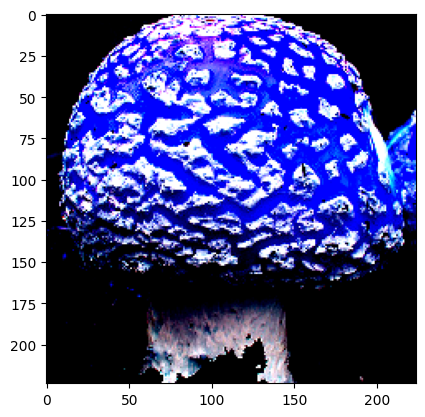

In [71]:
img, label = train_dataset[0]

print(label, img.shape)
plt.imshow(img.permute(1, 2, 0))    # plt imshow는 H, W, C 형태의 입력이 요구됨.

## Part B. ViT Implementation 

### Input to patch

In [72]:
# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.norm = nn.LayerNorm(dim)

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout),
                FeedForward(dim, mlp_dim, dropout = dropout)
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x

        return self.norm(x)

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Linear(dim, num_classes)

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [73]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device is', device)

device is cuda:0


In [88]:
# Create the ViT model
model = ViT(
    image_size = 224,
    patch_size = 32,
    num_classes = 1000,
    dim = 768,
    depth = 12,
    heads = 12,
    mlp_dim = 3072,
    dropout = 0.1,
    emb_dropout = 0.1
)

# Loss fucntion and optimizer
criterion = nn.CrossEntropyLoss()

In [101]:
model.to(device)

num_epochs = 400
train_losses = []
val_losses = []

base_lr = 3e-3
optimizer = optim.Adam(model.parameters(), lr=base_lr, betas=(0.9, 0.999), weight_decay=0.3)


warmup_steps = 10000
total_steps = (len(train_dataset) // batch_size) * num_epochs
warmup_steps = min(warmup_steps, total_steps)

warmup_scheduler = LinearLR(
    optimizer,
    start_factor=1e-6,  # Start with a very small LR (close to 0)
    end_factor=base_lr, 
    total_iters=warmup_steps,
)

# Cosine Decay (after warmup)
cosine_scheduler = CosineAnnealingLR(
    optimizer,
    T_max=total_steps - warmup_steps,  # Remaining steps after warmup
    eta_min=0,  # Minimum learning rate
)

# Combine them sequentially
scheduler = SequentialLR(
    optimizer,
    schedulers=[warmup_scheduler, cosine_scheduler],
    milestones=[warmup_steps],  # Switch to cosine after warmup
)

In [102]:
print(total_steps, warmup_steps)

19600 10000


In [103]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    with tqdm(train_loader, desc="Training", leave=True) as pbar:
       
        for batch_idx, (images, labels) in enumerate(pbar):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            # Gradient Clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            scheduler.step()
            running_loss += loss.item()

            avg_loss = running_loss / (batch_idx + 1)
            pbar.set_postfix(loss=avg_loss)
            
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
    

    model.eval()
    running_loss = 0.0
    accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=1000).to(device)
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Update metric
            predictions = torch.argmax(outputs, dim=1)
            accuracy_metric.update(predictions, labels)
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    val_loss = running_loss / len(val_loader)
    val_losses.append(val_loss)

    validation_accuracy = accuracy_metric.compute()
    print(f"Validation Accuracy: {validation_accuracy:.4f}")

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} \n')

Training: 100%|██████████| 50/50 [00:07<00:00,  6.72it/s, loss=6.72]


Validation Accuracy: 0.0013
Epoch [1/400], Train Loss: 6.7244, Val Loss: 7.0504 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.73it/s, loss=6.72]


Validation Accuracy: 0.0013
Epoch [2/400], Train Loss: 6.7246, Val Loss: 7.0504 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.74it/s, loss=6.72]


Validation Accuracy: 0.0026
Epoch [3/400], Train Loss: 6.7240, Val Loss: 7.0505 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.71it/s, loss=6.72]


Validation Accuracy: 0.0013
Epoch [4/400], Train Loss: 6.7161, Val Loss: 7.0506 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.65it/s, loss=6.71]


Validation Accuracy: 0.0026
Epoch [5/400], Train Loss: 6.7136, Val Loss: 7.0508 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.70it/s, loss=6.72]


Validation Accuracy: 0.0013
Epoch [6/400], Train Loss: 6.7196, Val Loss: 7.0510 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.64it/s, loss=6.72]


Validation Accuracy: 0.0013
Epoch [7/400], Train Loss: 6.7247, Val Loss: 7.0514 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.67it/s, loss=6.73]


Validation Accuracy: 0.0013
Epoch [8/400], Train Loss: 6.7274, Val Loss: 7.0516 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.70it/s, loss=6.73]


Validation Accuracy: 0.0013
Epoch [9/400], Train Loss: 6.7295, Val Loss: 7.0518 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.70it/s, loss=6.73]


Validation Accuracy: 0.0013
Epoch [10/400], Train Loss: 6.7344, Val Loss: 7.0520 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.67it/s, loss=6.73]


Validation Accuracy: 0.0013
Epoch [11/400], Train Loss: 6.7325, Val Loss: 7.0525 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.64it/s, loss=6.74]


Validation Accuracy: 0.0013
Epoch [12/400], Train Loss: 6.7351, Val Loss: 7.0527 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.69it/s, loss=6.74]


Validation Accuracy: 0.0013
Epoch [13/400], Train Loss: 6.7367, Val Loss: 7.0531 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.70it/s, loss=6.74]


Validation Accuracy: 0.0013
Epoch [14/400], Train Loss: 6.7360, Val Loss: 7.0531 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.63it/s, loss=6.74]


Validation Accuracy: 0.0013
Epoch [15/400], Train Loss: 6.7449, Val Loss: 7.0534 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.68it/s, loss=6.74]


Validation Accuracy: 0.0013
Epoch [16/400], Train Loss: 6.7429, Val Loss: 7.0537 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.73it/s, loss=6.75]


Validation Accuracy: 0.0013
Epoch [17/400], Train Loss: 6.7473, Val Loss: 7.0538 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.68it/s, loss=6.75]


Validation Accuracy: 0.0013
Epoch [18/400], Train Loss: 6.7486, Val Loss: 7.0536 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.68it/s, loss=6.76]


Validation Accuracy: 0.0013
Epoch [19/400], Train Loss: 6.7556, Val Loss: 7.0541 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.68it/s, loss=6.76]


Validation Accuracy: 0.0013
Epoch [20/400], Train Loss: 6.7570, Val Loss: 7.0541 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.67it/s, loss=6.75]


Validation Accuracy: 0.0013
Epoch [21/400], Train Loss: 6.7526, Val Loss: 7.0548 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.70it/s, loss=6.76]


Validation Accuracy: 0.0013
Epoch [22/400], Train Loss: 6.7646, Val Loss: 7.0551 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.67it/s, loss=6.75]


Validation Accuracy: 0.0013
Epoch [23/400], Train Loss: 6.7528, Val Loss: 7.0552 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.73it/s, loss=6.77]


Validation Accuracy: 0.0026
Epoch [24/400], Train Loss: 6.7657, Val Loss: 7.0557 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.74it/s, loss=6.77]


Validation Accuracy: 0.0026
Epoch [25/400], Train Loss: 6.7670, Val Loss: 7.0556 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.71it/s, loss=6.77]


Validation Accuracy: 0.0026
Epoch [26/400], Train Loss: 6.7660, Val Loss: 7.0562 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.79it/s, loss=6.76]


Validation Accuracy: 0.0026
Epoch [27/400], Train Loss: 6.7645, Val Loss: 7.0566 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.69it/s, loss=6.77]


Validation Accuracy: 0.0026
Epoch [28/400], Train Loss: 6.7727, Val Loss: 7.0570 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.74it/s, loss=6.77]


Validation Accuracy: 0.0026
Epoch [29/400], Train Loss: 6.7666, Val Loss: 7.0571 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.67it/s, loss=6.77]


Validation Accuracy: 0.0026
Epoch [30/400], Train Loss: 6.7720, Val Loss: 7.0576 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.68it/s, loss=6.77]


Validation Accuracy: 0.0026
Epoch [31/400], Train Loss: 6.7738, Val Loss: 7.0581 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.65it/s, loss=6.77]


Validation Accuracy: 0.0026
Epoch [32/400], Train Loss: 6.7670, Val Loss: 7.0586 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.68it/s, loss=6.78]


Validation Accuracy: 0.0026
Epoch [33/400], Train Loss: 6.7796, Val Loss: 7.0591 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.69it/s, loss=6.77]


Validation Accuracy: 0.0026
Epoch [34/400], Train Loss: 6.7746, Val Loss: 7.0592 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.67it/s, loss=6.77]


Validation Accuracy: 0.0026
Epoch [35/400], Train Loss: 6.7726, Val Loss: 7.0598 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.64it/s, loss=6.78]


Validation Accuracy: 0.0026
Epoch [36/400], Train Loss: 6.7802, Val Loss: 7.0600 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.67it/s, loss=6.79]


Validation Accuracy: 0.0026
Epoch [37/400], Train Loss: 6.7879, Val Loss: 7.0600 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.68it/s, loss=6.79]


Validation Accuracy: 0.0026
Epoch [38/400], Train Loss: 6.7896, Val Loss: 7.0596 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.70it/s, loss=6.78]


Validation Accuracy: 0.0026
Epoch [39/400], Train Loss: 6.7843, Val Loss: 7.0598 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.73it/s, loss=6.79]


Validation Accuracy: 0.0026
Epoch [40/400], Train Loss: 6.7881, Val Loss: 7.0602 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.68it/s, loss=6.79]


Validation Accuracy: 0.0026
Epoch [41/400], Train Loss: 6.7871, Val Loss: 7.0606 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.63it/s, loss=6.8] 


Validation Accuracy: 0.0026
Epoch [42/400], Train Loss: 6.7960, Val Loss: 7.0608 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.68it/s, loss=6.79]


Validation Accuracy: 0.0026
Epoch [43/400], Train Loss: 6.7950, Val Loss: 7.0610 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.72it/s, loss=6.79]


Validation Accuracy: 0.0026
Epoch [44/400], Train Loss: 6.7917, Val Loss: 7.0615 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.72it/s, loss=6.8] 


Validation Accuracy: 0.0038
Epoch [45/400], Train Loss: 6.7955, Val Loss: 7.0617 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.65it/s, loss=6.8] 


Validation Accuracy: 0.0038
Epoch [46/400], Train Loss: 6.8031, Val Loss: 7.0620 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.68it/s, loss=6.8] 


Validation Accuracy: 0.0038
Epoch [47/400], Train Loss: 6.8034, Val Loss: 7.0620 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.73it/s, loss=6.8] 


Validation Accuracy: 0.0038
Epoch [48/400], Train Loss: 6.7964, Val Loss: 7.0622 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.68it/s, loss=6.81]


Validation Accuracy: 0.0038
Epoch [49/400], Train Loss: 6.8059, Val Loss: 7.0626 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.67it/s, loss=6.8] 


Validation Accuracy: 0.0038
Epoch [50/400], Train Loss: 6.8027, Val Loss: 7.0628 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.70it/s, loss=6.8] 


Validation Accuracy: 0.0038
Epoch [51/400], Train Loss: 6.8010, Val Loss: 7.0630 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.71it/s, loss=6.81]


Validation Accuracy: 0.0038
Epoch [52/400], Train Loss: 6.8076, Val Loss: 7.0635 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.69it/s, loss=6.8] 


Validation Accuracy: 0.0038
Epoch [53/400], Train Loss: 6.8045, Val Loss: 7.0634 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.66it/s, loss=6.8] 


Validation Accuracy: 0.0026
Epoch [54/400], Train Loss: 6.8036, Val Loss: 7.0637 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.64it/s, loss=6.81]


Validation Accuracy: 0.0038
Epoch [55/400], Train Loss: 6.8095, Val Loss: 7.0637 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.68it/s, loss=6.81]


Validation Accuracy: 0.0026
Epoch [56/400], Train Loss: 6.8089, Val Loss: 7.0639 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.62it/s, loss=6.82]


Validation Accuracy: 0.0026
Epoch [57/400], Train Loss: 6.8162, Val Loss: 7.0640 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.67it/s, loss=6.81]


Validation Accuracy: 0.0026
Epoch [58/400], Train Loss: 6.8088, Val Loss: 7.0641 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.64it/s, loss=6.81]


Validation Accuracy: 0.0026
Epoch [59/400], Train Loss: 6.8109, Val Loss: 7.0648 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.67it/s, loss=6.82]


Validation Accuracy: 0.0026
Epoch [60/400], Train Loss: 6.8171, Val Loss: 7.0648 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.70it/s, loss=6.81]


Validation Accuracy: 0.0026
Epoch [61/400], Train Loss: 6.8094, Val Loss: 7.0645 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.66it/s, loss=6.82]


Validation Accuracy: 0.0026
Epoch [62/400], Train Loss: 6.8160, Val Loss: 7.0649 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.69it/s, loss=6.81]


Validation Accuracy: 0.0026
Epoch [63/400], Train Loss: 6.8102, Val Loss: 7.0650 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.70it/s, loss=6.81]


Validation Accuracy: 0.0026
Epoch [64/400], Train Loss: 6.8141, Val Loss: 7.0650 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.69it/s, loss=6.82]


Validation Accuracy: 0.0026
Epoch [65/400], Train Loss: 6.8187, Val Loss: 7.0652 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.66it/s, loss=6.82]


Validation Accuracy: 0.0026
Epoch [66/400], Train Loss: 6.8160, Val Loss: 7.0652 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.65it/s, loss=6.82]


Validation Accuracy: 0.0026
Epoch [67/400], Train Loss: 6.8190, Val Loss: 7.0655 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.69it/s, loss=6.82]


Validation Accuracy: 0.0026
Epoch [68/400], Train Loss: 6.8207, Val Loss: 7.0657 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.71it/s, loss=6.82]


Validation Accuracy: 0.0026
Epoch [69/400], Train Loss: 6.8151, Val Loss: 7.0655 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.61it/s, loss=6.82]


Validation Accuracy: 0.0038
Epoch [70/400], Train Loss: 6.8213, Val Loss: 7.0659 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.65it/s, loss=6.82]


Validation Accuracy: 0.0026
Epoch [71/400], Train Loss: 6.8192, Val Loss: 7.0663 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.64it/s, loss=6.81]


Validation Accuracy: 0.0026
Epoch [72/400], Train Loss: 6.8138, Val Loss: 7.0663 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.63it/s, loss=6.81]


Validation Accuracy: 0.0026
Epoch [73/400], Train Loss: 6.8135, Val Loss: 7.0665 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.66it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [74/400], Train Loss: 6.8251, Val Loss: 7.0665 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.67it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [75/400], Train Loss: 6.8286, Val Loss: 7.0665 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.67it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [76/400], Train Loss: 6.8277, Val Loss: 7.0665 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.68it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [77/400], Train Loss: 6.8253, Val Loss: 7.0665 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.71it/s, loss=6.82]


Validation Accuracy: 0.0026
Epoch [78/400], Train Loss: 6.8174, Val Loss: 7.0670 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.69it/s, loss=6.82]


Validation Accuracy: 0.0026
Epoch [79/400], Train Loss: 6.8244, Val Loss: 7.0669 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.69it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [80/400], Train Loss: 6.8295, Val Loss: 7.0671 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.70it/s, loss=6.82]


Validation Accuracy: 0.0026
Epoch [81/400], Train Loss: 6.8188, Val Loss: 7.0665 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.74it/s, loss=6.82]


Validation Accuracy: 0.0026
Epoch [82/400], Train Loss: 6.8241, Val Loss: 7.0672 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.72it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [83/400], Train Loss: 6.8252, Val Loss: 7.0671 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.70it/s, loss=6.82]


Validation Accuracy: 0.0026
Epoch [84/400], Train Loss: 6.8202, Val Loss: 7.0672 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.71it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [85/400], Train Loss: 6.8304, Val Loss: 7.0674 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.71it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [86/400], Train Loss: 6.8263, Val Loss: 7.0670 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.73it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [87/400], Train Loss: 6.8266, Val Loss: 7.0673 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.68it/s, loss=6.82]


Validation Accuracy: 0.0026
Epoch [88/400], Train Loss: 6.8216, Val Loss: 7.0676 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.69it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [89/400], Train Loss: 6.8308, Val Loss: 7.0676 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.61it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [90/400], Train Loss: 6.8254, Val Loss: 7.0674 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.70it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [91/400], Train Loss: 6.8306, Val Loss: 7.0674 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.65it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [92/400], Train Loss: 6.8318, Val Loss: 7.0675 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.72it/s, loss=6.82]


Validation Accuracy: 0.0026
Epoch [93/400], Train Loss: 6.8242, Val Loss: 7.0676 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.73it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [94/400], Train Loss: 6.8273, Val Loss: 7.0676 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.71it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [95/400], Train Loss: 6.8300, Val Loss: 7.0679 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.68it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [96/400], Train Loss: 6.8317, Val Loss: 7.0677 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.69it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [97/400], Train Loss: 6.8270, Val Loss: 7.0675 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.67it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [98/400], Train Loss: 6.8317, Val Loss: 7.0675 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.70it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [99/400], Train Loss: 6.8297, Val Loss: 7.0673 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.63it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [100/400], Train Loss: 6.8312, Val Loss: 7.0676 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.74it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [101/400], Train Loss: 6.8252, Val Loss: 7.0675 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.65it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [102/400], Train Loss: 6.8337, Val Loss: 7.0675 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.67it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [103/400], Train Loss: 6.8306, Val Loss: 7.0673 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.64it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [104/400], Train Loss: 6.8298, Val Loss: 7.0669 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.69it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [105/400], Train Loss: 6.8321, Val Loss: 7.0667 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.70it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [106/400], Train Loss: 6.8322, Val Loss: 7.0666 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.71it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [107/400], Train Loss: 6.8272, Val Loss: 7.0664 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.70it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [108/400], Train Loss: 6.8339, Val Loss: 7.0659 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.69it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [109/400], Train Loss: 6.8300, Val Loss: 7.0666 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.71it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [110/400], Train Loss: 6.8316, Val Loss: 7.0662 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.67it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [111/400], Train Loss: 6.8281, Val Loss: 7.0661 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.73it/s, loss=6.82]


Validation Accuracy: 0.0026
Epoch [112/400], Train Loss: 6.8245, Val Loss: 7.0661 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.67it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [113/400], Train Loss: 6.8321, Val Loss: 7.0661 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.67it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [114/400], Train Loss: 6.8340, Val Loss: 7.0665 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.64it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [115/400], Train Loss: 6.8297, Val Loss: 7.0658 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.67it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [116/400], Train Loss: 6.8308, Val Loss: 7.0662 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.70it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [117/400], Train Loss: 6.8289, Val Loss: 7.0663 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.64it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [118/400], Train Loss: 6.8319, Val Loss: 7.0658 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.63it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [119/400], Train Loss: 6.8275, Val Loss: 7.0653 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.74it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [120/400], Train Loss: 6.8295, Val Loss: 7.0658 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.63it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [121/400], Train Loss: 6.8295, Val Loss: 7.0657 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.68it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [122/400], Train Loss: 6.8333, Val Loss: 7.0655 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.70it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [123/400], Train Loss: 6.8285, Val Loss: 7.0650 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.67it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [124/400], Train Loss: 6.8294, Val Loss: 7.0654 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.74it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [125/400], Train Loss: 6.8296, Val Loss: 7.0651 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.69it/s, loss=6.82]


Validation Accuracy: 0.0026
Epoch [126/400], Train Loss: 6.8237, Val Loss: 7.0656 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.68it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [127/400], Train Loss: 6.8318, Val Loss: 7.0652 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.62it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [128/400], Train Loss: 6.8295, Val Loss: 7.0657 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.67it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [129/400], Train Loss: 6.8296, Val Loss: 7.0655 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.68it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [130/400], Train Loss: 6.8278, Val Loss: 7.0656 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.71it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [131/400], Train Loss: 6.8272, Val Loss: 7.0659 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.68it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [132/400], Train Loss: 6.8260, Val Loss: 7.0656 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.68it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [133/400], Train Loss: 6.8297, Val Loss: 7.0657 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.64it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [134/400], Train Loss: 6.8344, Val Loss: 7.0657 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.63it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [135/400], Train Loss: 6.8258, Val Loss: 7.0657 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.68it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [136/400], Train Loss: 6.8308, Val Loss: 7.0661 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.69it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [137/400], Train Loss: 6.8327, Val Loss: 7.0654 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.68it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [138/400], Train Loss: 6.8306, Val Loss: 7.0658 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.72it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [139/400], Train Loss: 6.8266, Val Loss: 7.0657 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.65it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [140/400], Train Loss: 6.8319, Val Loss: 7.0655 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.67it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [141/400], Train Loss: 6.8281, Val Loss: 7.0655 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.67it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [142/400], Train Loss: 6.8266, Val Loss: 7.0656 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.76it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [143/400], Train Loss: 6.8293, Val Loss: 7.0655 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.64it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [144/400], Train Loss: 6.8314, Val Loss: 7.0656 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.67it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [145/400], Train Loss: 6.8273, Val Loss: 7.0659 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.68it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [146/400], Train Loss: 6.8264, Val Loss: 7.0659 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.68it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [147/400], Train Loss: 6.8307, Val Loss: 7.0657 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.62it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [148/400], Train Loss: 6.8303, Val Loss: 7.0657 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.63it/s, loss=6.82]


Validation Accuracy: 0.0026
Epoch [149/400], Train Loss: 6.8248, Val Loss: 7.0661 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.70it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [150/400], Train Loss: 6.8291, Val Loss: 7.0662 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.71it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [151/400], Train Loss: 6.8262, Val Loss: 7.0660 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.68it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [152/400], Train Loss: 6.8277, Val Loss: 7.0661 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.66it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [153/400], Train Loss: 6.8273, Val Loss: 7.0654 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.72it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [154/400], Train Loss: 6.8282, Val Loss: 7.0654 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.68it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [155/400], Train Loss: 6.8334, Val Loss: 7.0652 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.63it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [156/400], Train Loss: 6.8269, Val Loss: 7.0647 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.58it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [157/400], Train Loss: 6.8279, Val Loss: 7.0646 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.66it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [158/400], Train Loss: 6.8266, Val Loss: 7.0648 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.71it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [159/400], Train Loss: 6.8274, Val Loss: 7.0648 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.69it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [160/400], Train Loss: 6.8301, Val Loss: 7.0650 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.69it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [161/400], Train Loss: 6.8338, Val Loss: 7.0654 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.68it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [162/400], Train Loss: 6.8268, Val Loss: 7.0654 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.71it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [163/400], Train Loss: 6.8295, Val Loss: 7.0653 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.70it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [164/400], Train Loss: 6.8303, Val Loss: 7.0649 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.69it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [165/400], Train Loss: 6.8277, Val Loss: 7.0647 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.67it/s, loss=6.84]


Validation Accuracy: 0.0026
Epoch [166/400], Train Loss: 6.8364, Val Loss: 7.0647 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.66it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [167/400], Train Loss: 6.8308, Val Loss: 7.0642 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.68it/s, loss=6.84]


Validation Accuracy: 0.0026
Epoch [168/400], Train Loss: 6.8370, Val Loss: 7.0644 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.68it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [169/400], Train Loss: 6.8252, Val Loss: 7.0640 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.68it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [170/400], Train Loss: 6.8332, Val Loss: 7.0644 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.70it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [171/400], Train Loss: 6.8317, Val Loss: 7.0643 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.65it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [172/400], Train Loss: 6.8302, Val Loss: 7.0643 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.65it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [173/400], Train Loss: 6.8332, Val Loss: 7.0647 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.64it/s, loss=6.82]


Validation Accuracy: 0.0026
Epoch [174/400], Train Loss: 6.8235, Val Loss: 7.0641 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.59it/s, loss=6.82]


Validation Accuracy: 0.0026
Epoch [175/400], Train Loss: 6.8218, Val Loss: 7.0642 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.75it/s, loss=6.82]


Validation Accuracy: 0.0026
Epoch [176/400], Train Loss: 6.8246, Val Loss: 7.0640 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.66it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [177/400], Train Loss: 6.8319, Val Loss: 7.0638 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.59it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [178/400], Train Loss: 6.8286, Val Loss: 7.0637 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.72it/s, loss=6.82]


Validation Accuracy: 0.0026
Epoch [179/400], Train Loss: 6.8250, Val Loss: 7.0638 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.64it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [180/400], Train Loss: 6.8341, Val Loss: 7.0645 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.68it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [181/400], Train Loss: 6.8301, Val Loss: 7.0643 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.68it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [182/400], Train Loss: 6.8311, Val Loss: 7.0638 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.69it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [183/400], Train Loss: 6.8319, Val Loss: 7.0643 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.66it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [184/400], Train Loss: 6.8270, Val Loss: 7.0635 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.73it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [185/400], Train Loss: 6.8333, Val Loss: 7.0640 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.65it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [186/400], Train Loss: 6.8322, Val Loss: 7.0648 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.66it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [187/400], Train Loss: 6.8266, Val Loss: 7.0646 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.76it/s, loss=6.82]


Validation Accuracy: 0.0026
Epoch [188/400], Train Loss: 6.8229, Val Loss: 7.0653 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.66it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [189/400], Train Loss: 6.8312, Val Loss: 7.0652 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.63it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [190/400], Train Loss: 6.8338, Val Loss: 7.0658 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.74it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [191/400], Train Loss: 6.8264, Val Loss: 7.0655 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.70it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [192/400], Train Loss: 6.8320, Val Loss: 7.0657 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.67it/s, loss=6.84]


Validation Accuracy: 0.0026
Epoch [193/400], Train Loss: 6.8361, Val Loss: 7.0657 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.69it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [194/400], Train Loss: 6.8327, Val Loss: 7.0660 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.70it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [195/400], Train Loss: 6.8349, Val Loss: 7.0656 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.72it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [196/400], Train Loss: 6.8346, Val Loss: 7.0655 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.67it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [197/400], Train Loss: 6.8321, Val Loss: 7.0648 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.67it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [198/400], Train Loss: 6.8334, Val Loss: 7.0647 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.69it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [199/400], Train Loss: 6.8302, Val Loss: 7.0647 



Training:  98%|█████████▊| 49/50 [00:07<00:00,  7.10it/s, loss=6.83]/NAS2/choah76/miniconda3/envs/transINR/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Training: 100%|██████████| 50/50 [00:07<00:00,  6.68it/s, loss=6.83]


Validation Accuracy: 0.0026
Epoch [200/400], Train Loss: 6.8297, Val Loss: 7.0650 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.61it/s, loss=7.86]


Validation Accuracy: 0.0013
Epoch [201/400], Train Loss: 7.8555, Val Loss: 7.2310 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.69it/s, loss=7.35]


Validation Accuracy: 0.0026
Epoch [202/400], Train Loss: 7.3486, Val Loss: 7.3275 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.65it/s, loss=7.2] 


Validation Accuracy: 0.0026
Epoch [203/400], Train Loss: 7.1998, Val Loss: 7.2304 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.67it/s, loss=7.11]


Validation Accuracy: 0.0000
Epoch [204/400], Train Loss: 7.1132, Val Loss: 7.1320 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.75it/s, loss=7.05]


Validation Accuracy: 0.0000
Epoch [205/400], Train Loss: 7.0474, Val Loss: 7.0594 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.72it/s, loss=7]   


Validation Accuracy: 0.0026
Epoch [206/400], Train Loss: 7.0014, Val Loss: 6.9898 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.64it/s, loss=6.97]


Validation Accuracy: 0.0000
Epoch [207/400], Train Loss: 6.9703, Val Loss: 6.9569 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.73it/s, loss=6.95]


Validation Accuracy: 0.0013
Epoch [208/400], Train Loss: 6.9526, Val Loss: 6.9390 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.70it/s, loss=6.93]


Validation Accuracy: 0.0000
Epoch [209/400], Train Loss: 6.9317, Val Loss: 6.9320 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.74it/s, loss=6.92]


Validation Accuracy: 0.0000
Epoch [210/400], Train Loss: 6.9217, Val Loss: 6.9158 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.68it/s, loss=6.92]


Validation Accuracy: 0.0026
Epoch [211/400], Train Loss: 6.9176, Val Loss: 6.9131 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.67it/s, loss=6.91]


Validation Accuracy: 0.0013
Epoch [212/400], Train Loss: 6.9132, Val Loss: 6.9128 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.71it/s, loss=6.91]


Validation Accuracy: 0.0013
Epoch [213/400], Train Loss: 6.9118, Val Loss: 6.9106 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.74it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [214/400], Train Loss: 6.9095, Val Loss: 6.9100 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.75it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [215/400], Train Loss: 6.9090, Val Loss: 6.9099 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.71it/s, loss=6.91]


Validation Accuracy: 0.0038
Epoch [216/400], Train Loss: 6.9087, Val Loss: 6.9092 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.70it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [217/400], Train Loss: 6.9083, Val Loss: 6.9090 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.69it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [218/400], Train Loss: 6.9083, Val Loss: 6.9088 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.73it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [219/400], Train Loss: 6.9083, Val Loss: 6.9085 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.76it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [220/400], Train Loss: 6.9081, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.81it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [221/400], Train Loss: 6.9081, Val Loss: 6.9080 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.79it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [222/400], Train Loss: 6.9080, Val Loss: 6.9085 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.76it/s, loss=6.91]


Validation Accuracy: 0.0013
Epoch [223/400], Train Loss: 6.9082, Val Loss: 6.9083 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.80it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [224/400], Train Loss: 6.9080, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.75it/s, loss=6.91]


Validation Accuracy: 0.0013
Epoch [225/400], Train Loss: 6.9080, Val Loss: 6.9080 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.76it/s, loss=6.91]


Validation Accuracy: 0.0013
Epoch [226/400], Train Loss: 6.9081, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.77it/s, loss=6.91]


Validation Accuracy: 0.0013
Epoch [227/400], Train Loss: 6.9080, Val Loss: 6.9083 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.78it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [228/400], Train Loss: 6.9080, Val Loss: 6.9083 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.81it/s, loss=6.91]


Validation Accuracy: 0.0013
Epoch [229/400], Train Loss: 6.9080, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.72it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [230/400], Train Loss: 6.9081, Val Loss: 6.9084 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.80it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [231/400], Train Loss: 6.9081, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.75it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [232/400], Train Loss: 6.9080, Val Loss: 6.9080 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.84it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [233/400], Train Loss: 6.9079, Val Loss: 6.9083 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.86it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [234/400], Train Loss: 6.9081, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.85it/s, loss=6.91]


Validation Accuracy: 0.0013
Epoch [235/400], Train Loss: 6.9080, Val Loss: 6.9080 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.90it/s, loss=6.91]


Validation Accuracy: 0.0013
Epoch [236/400], Train Loss: 6.9080, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.90it/s, loss=6.91]


Validation Accuracy: 0.0013
Epoch [237/400], Train Loss: 6.9079, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.92it/s, loss=6.91]


Validation Accuracy: 0.0013
Epoch [238/400], Train Loss: 6.9079, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.96it/s, loss=6.91]


Validation Accuracy: 0.0013
Epoch [239/400], Train Loss: 6.9079, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.89it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [240/400], Train Loss: 6.9079, Val Loss: 6.9083 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.90it/s, loss=6.91]


Validation Accuracy: 0.0013
Epoch [241/400], Train Loss: 6.9081, Val Loss: 6.9084 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.85it/s, loss=6.91]


Validation Accuracy: 0.0013
Epoch [242/400], Train Loss: 6.9080, Val Loss: 6.9083 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.86it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [243/400], Train Loss: 6.9079, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.94it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [244/400], Train Loss: 6.9080, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.91it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [245/400], Train Loss: 6.9082, Val Loss: 6.9080 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.87it/s, loss=6.91]


Validation Accuracy: 0.0013
Epoch [246/400], Train Loss: 6.9080, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.90it/s, loss=6.91]


Validation Accuracy: 0.0013
Epoch [247/400], Train Loss: 6.9079, Val Loss: 6.9083 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.89it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [248/400], Train Loss: 6.9080, Val Loss: 6.9083 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.98it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [249/400], Train Loss: 6.9081, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.88it/s, loss=6.91]


Validation Accuracy: 0.0013
Epoch [250/400], Train Loss: 6.9080, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.88it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [251/400], Train Loss: 6.9079, Val Loss: 6.9078 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.82it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [252/400], Train Loss: 6.9080, Val Loss: 6.9083 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.94it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [253/400], Train Loss: 6.9081, Val Loss: 6.9083 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.98it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [254/400], Train Loss: 6.9080, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.89it/s, loss=6.91]


Validation Accuracy: 0.0013
Epoch [255/400], Train Loss: 6.9080, Val Loss: 6.9084 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.86it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [256/400], Train Loss: 6.9080, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.91it/s, loss=6.91]


Validation Accuracy: 0.0013
Epoch [257/400], Train Loss: 6.9080, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.94it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [258/400], Train Loss: 6.9081, Val Loss: 6.9083 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.94it/s, loss=6.91]


Validation Accuracy: 0.0013
Epoch [259/400], Train Loss: 6.9080, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.93it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [260/400], Train Loss: 6.9080, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.95it/s, loss=6.91]


Validation Accuracy: 0.0013
Epoch [261/400], Train Loss: 6.9080, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.92it/s, loss=6.91]


Validation Accuracy: 0.0013
Epoch [262/400], Train Loss: 6.9080, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.92it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [263/400], Train Loss: 6.9080, Val Loss: 6.9083 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.90it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [264/400], Train Loss: 6.9080, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.87it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [265/400], Train Loss: 6.9080, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.92it/s, loss=6.91]


Validation Accuracy: 0.0013
Epoch [266/400], Train Loss: 6.9081, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.96it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [267/400], Train Loss: 6.9079, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.95it/s, loss=6.91]


Validation Accuracy: 0.0013
Epoch [268/400], Train Loss: 6.9079, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.94it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [269/400], Train Loss: 6.9079, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.98it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [270/400], Train Loss: 6.9079, Val Loss: 6.9084 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.90it/s, loss=6.91]


Validation Accuracy: 0.0013
Epoch [271/400], Train Loss: 6.9081, Val Loss: 6.9083 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.97it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [272/400], Train Loss: 6.9079, Val Loss: 6.9080 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.97it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [273/400], Train Loss: 6.9080, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.96it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [274/400], Train Loss: 6.9079, Val Loss: 6.9083 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.99it/s, loss=6.91]


Validation Accuracy: 0.0013
Epoch [275/400], Train Loss: 6.9081, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.97it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [276/400], Train Loss: 6.9080, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.96it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [277/400], Train Loss: 6.9079, Val Loss: 6.9083 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.92it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [278/400], Train Loss: 6.9080, Val Loss: 6.9083 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.99it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [279/400], Train Loss: 6.9080, Val Loss: 6.9083 



Training: 100%|██████████| 50/50 [00:07<00:00,  7.01it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [280/400], Train Loss: 6.9080, Val Loss: 6.9084 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.98it/s, loss=6.91]


Validation Accuracy: 0.0013
Epoch [281/400], Train Loss: 6.9080, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.88it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [282/400], Train Loss: 6.9080, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.89it/s, loss=6.91]


Validation Accuracy: 0.0051
Epoch [283/400], Train Loss: 6.9080, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:07<00:00,  7.01it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [284/400], Train Loss: 6.9079, Val Loss: 6.9079 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.97it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [285/400], Train Loss: 6.9079, Val Loss: 6.9083 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.95it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [286/400], Train Loss: 6.9079, Val Loss: 6.9083 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.94it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [287/400], Train Loss: 6.9079, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.94it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [288/400], Train Loss: 6.9080, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.90it/s, loss=6.91]


Validation Accuracy: 0.0013
Epoch [289/400], Train Loss: 6.9080, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.95it/s, loss=6.91]


Validation Accuracy: 0.0013
Epoch [290/400], Train Loss: 6.9080, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.96it/s, loss=6.91]


Validation Accuracy: 0.0051
Epoch [291/400], Train Loss: 6.9080, Val Loss: 6.9080 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.96it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [292/400], Train Loss: 6.9079, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.88it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [293/400], Train Loss: 6.9079, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.89it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [294/400], Train Loss: 6.9079, Val Loss: 6.9083 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.94it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [295/400], Train Loss: 6.9079, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.97it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [296/400], Train Loss: 6.9079, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.97it/s, loss=6.91]


Validation Accuracy: 0.0013
Epoch [297/400], Train Loss: 6.9079, Val Loss: 6.9080 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.94it/s, loss=6.91]


Validation Accuracy: 0.0013
Epoch [298/400], Train Loss: 6.9079, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.82it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [299/400], Train Loss: 6.9080, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.86it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [300/400], Train Loss: 6.9079, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.94it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [301/400], Train Loss: 6.9079, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.89it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [302/400], Train Loss: 6.9078, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  7.00it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [303/400], Train Loss: 6.9079, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.92it/s, loss=6.91]


Validation Accuracy: 0.0013
Epoch [304/400], Train Loss: 6.9079, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.97it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [305/400], Train Loss: 6.9079, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.92it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [306/400], Train Loss: 6.9079, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.83it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [307/400], Train Loss: 6.9079, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.88it/s, loss=6.91]


Validation Accuracy: 0.0013
Epoch [308/400], Train Loss: 6.9079, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.92it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [309/400], Train Loss: 6.9079, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.95it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [310/400], Train Loss: 6.9079, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.94it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [311/400], Train Loss: 6.9079, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.95it/s, loss=6.91]


Validation Accuracy: 0.0013
Epoch [312/400], Train Loss: 6.9078, Val Loss: 6.9080 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.98it/s, loss=6.91]


Validation Accuracy: 0.0013
Epoch [313/400], Train Loss: 6.9079, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.92it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [314/400], Train Loss: 6.9078, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:07<00:00,  7.04it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [315/400], Train Loss: 6.9079, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.99it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [316/400], Train Loss: 6.9078, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.96it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [317/400], Train Loss: 6.9078, Val Loss: 6.9083 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.93it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [318/400], Train Loss: 6.9078, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.98it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [319/400], Train Loss: 6.9078, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.96it/s, loss=6.91]


Validation Accuracy: 0.0013
Epoch [320/400], Train Loss: 6.9078, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:07<00:00,  6.97it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [321/400], Train Loss: 6.9077, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:07<00:00,  7.05it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [322/400], Train Loss: 6.9078, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:07<00:00,  7.03it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [323/400], Train Loss: 6.9077, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  7.10it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [324/400], Train Loss: 6.9078, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  7.01it/s, loss=6.91]


Validation Accuracy: 0.0013
Epoch [325/400], Train Loss: 6.9077, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  7.07it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [326/400], Train Loss: 6.9077, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  7.06it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [327/400], Train Loss: 6.9076, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  7.13it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [328/400], Train Loss: 6.9076, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:07<00:00,  7.13it/s, loss=6.91]


Validation Accuracy: 0.0013
Epoch [329/400], Train Loss: 6.9077, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  7.14it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [330/400], Train Loss: 6.9077, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:07<00:00,  7.10it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [331/400], Train Loss: 6.9077, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.19it/s, loss=6.91]


Validation Accuracy: 0.0013
Epoch [332/400], Train Loss: 6.9077, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.18it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [333/400], Train Loss: 6.9077, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  7.05it/s, loss=6.91]


Validation Accuracy: 0.0013
Epoch [334/400], Train Loss: 6.9076, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.15it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [335/400], Train Loss: 6.9076, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.19it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [336/400], Train Loss: 6.9076, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:07<00:00,  7.09it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [337/400], Train Loss: 6.9076, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  7.09it/s, loss=6.91]


Validation Accuracy: 0.0013
Epoch [338/400], Train Loss: 6.9076, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  7.12it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [339/400], Train Loss: 6.9076, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:07<00:00,  7.10it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [340/400], Train Loss: 6.9076, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.17it/s, loss=6.91]


Validation Accuracy: 0.0013
Epoch [341/400], Train Loss: 6.9076, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:07<00:00,  7.07it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [342/400], Train Loss: 6.9076, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.16it/s, loss=6.91]


Validation Accuracy: 0.0013
Epoch [343/400], Train Loss: 6.9075, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.18it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [344/400], Train Loss: 6.9075, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.20it/s, loss=6.91]


Validation Accuracy: 0.0013
Epoch [345/400], Train Loss: 6.9075, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.19it/s, loss=6.91]


Validation Accuracy: 0.0013
Epoch [346/400], Train Loss: 6.9075, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  7.12it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [347/400], Train Loss: 6.9075, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.21it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [348/400], Train Loss: 6.9075, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  7.14it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [349/400], Train Loss: 6.9075, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.21it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [350/400], Train Loss: 6.9074, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.15it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [351/400], Train Loss: 6.9074, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.19it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [352/400], Train Loss: 6.9074, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.23it/s, loss=6.91]


Validation Accuracy: 0.0000
Epoch [353/400], Train Loss: 6.9074, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.19it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [354/400], Train Loss: 6.9074, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:07<00:00,  7.14it/s, loss=6.91]


Validation Accuracy: 0.0064
Epoch [355/400], Train Loss: 6.9074, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:07<00:00,  7.13it/s, loss=6.91]


Validation Accuracy: 0.0064
Epoch [356/400], Train Loss: 6.9074, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.23it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [357/400], Train Loss: 6.9074, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.18it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [358/400], Train Loss: 6.9074, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.19it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [359/400], Train Loss: 6.9074, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.16it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [360/400], Train Loss: 6.9073, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.21it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [361/400], Train Loss: 6.9073, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.21it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [362/400], Train Loss: 6.9073, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:07<00:00,  7.11it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [363/400], Train Loss: 6.9073, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.26it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [364/400], Train Loss: 6.9073, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.22it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [365/400], Train Loss: 6.9073, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:07<00:00,  7.10it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [366/400], Train Loss: 6.9073, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.14it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [367/400], Train Loss: 6.9073, Val Loss: 6.9081 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.15it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [368/400], Train Loss: 6.9072, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  7.01it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [369/400], Train Loss: 6.9072, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.22it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [370/400], Train Loss: 6.9072, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  7.11it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [371/400], Train Loss: 6.9072, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  7.07it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [372/400], Train Loss: 6.9072, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.20it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [373/400], Train Loss: 6.9072, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.18it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [374/400], Train Loss: 6.9072, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.18it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [375/400], Train Loss: 6.9072, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.25it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [376/400], Train Loss: 6.9072, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.20it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [377/400], Train Loss: 6.9072, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.21it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [378/400], Train Loss: 6.9071, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.15it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [379/400], Train Loss: 6.9072, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.18it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [380/400], Train Loss: 6.9071, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.22it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [381/400], Train Loss: 6.9071, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  7.12it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [382/400], Train Loss: 6.9071, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.20it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [383/400], Train Loss: 6.9071, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.21it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [384/400], Train Loss: 6.9071, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.15it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [385/400], Train Loss: 6.9071, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.24it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [386/400], Train Loss: 6.9071, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.23it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [387/400], Train Loss: 6.9071, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  7.13it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [388/400], Train Loss: 6.9071, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.29it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [389/400], Train Loss: 6.9071, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.22it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [390/400], Train Loss: 6.9071, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.15it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [391/400], Train Loss: 6.9071, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.22it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [392/400], Train Loss: 6.9071, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.22it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [393/400], Train Loss: 6.9071, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.20it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [394/400], Train Loss: 6.9071, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.18it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [395/400], Train Loss: 6.9071, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.16it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [396/400], Train Loss: 6.9071, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.21it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [397/400], Train Loss: 6.9071, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:06<00:00,  7.16it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [398/400], Train Loss: 6.9071, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  7.12it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [399/400], Train Loss: 6.9071, Val Loss: 6.9082 



Training: 100%|██████████| 50/50 [00:07<00:00,  7.07it/s, loss=6.91]


Validation Accuracy: 0.0026
Epoch [400/400], Train Loss: 6.9071, Val Loss: 6.9082 



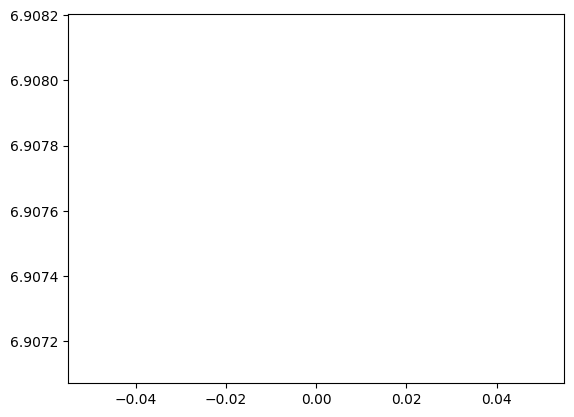

In [104]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.show()